In [10]:
# wd = '/mnt/openfact/users/msawinski/factue-task2'
wd = "/Users/marcinsawinski/Documents/GitHub/factue-task2"
import sys, os

os.chdir(wd)

In [11]:
import pandas as pd
from pathlib import Path
import os
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


root = Path("data/llm_output/persuasion/detect")
# Example path template
files_dev = root.rglob("*/dev/*/*.parquet")
files_train = root.rglob("*/train/*/*.parquet")
files = [x for x in files_dev] + [x for x in files_train]

# Read all files and add file path as a column
df_list = []
for f in files:
    df_part = pd.read_parquet(f)
    df_part["source_file"] = f  # add the file path
    df_list.append(df_part)

# Combine into one DataFrame
df = pd.concat(df_list, ignore_index=True)
df["model"] = df.source_file.astype(str).str.split("/", expand=True)[4]
df["split"] = df.source_file.astype(str).str.split("/", expand=True)[7]
df["lang"] = df.source_file.astype(str).str.split("/", expand=True)[8]
df["partno"] = (
    df.source_file.astype(str)
    .str.split("/", expand=True)[9]
    .str.split("_", expand=True)[1]
    .str.split(".", expand=True)[0]
    .astype(int)
)

In [12]:
df.model.value_counts()

model
LLAMA_31_8B           44730
DEEPSEEK_R1_8B        21790
OGPT_41_MINI_FT       21300
GPT_41_MINI           16300
GPT_4O_MINI           10715
GPT_41_MINI_FT2_31    10325
GPT_41_MINI_FT2_11    10325
GPT_41_MINI_FT2_21     8100
Name: count, dtype: int64

In [13]:
models = ["GPT_41_MINI", "OGPT_41_MINI_FT"]
models = [
    "GPT_41_MINI",
    "GPT_41_MINI_FT2_11",
    "GPT_41_MINI_FT2_21",
    "GPT_41_MINI_FT2_31",
    "OGPT_41_MINI_FT",
]
models = [
    "LLAMA_31_8B",
    "DEEPSEEK_R1_8B",
    "GPT_41_MINI",
    "OGPT_41_MINI_FT",
]
# models = [
#     "GPT_41_MINI",
#     "GPT_41_MINI_FT2_11",
#     "GPT_41_MINI_FT2_21",
#     "GPT_41_MINI_FT2_31",

# ]
df = df[df.model.isin(models)]

In [14]:
df_counts = (
    df[(df["partno"] < 10) & (df["split"] == "dev")]
    .groupby(
        [
            "prompt_version",
            "prompt_name",
            "model",
            "split",
            "lang",
        ]
    )
    .agg(count=("source_file", "nunique"))
    .reset_index()
    .pivot_table(
        index=[
            "model",
            "prompt_version",
        ],
        columns=[
            "lang",
        ],
        values="count",
        aggfunc="sum",
    )
)
df_counts.reset_index()

lang,model,prompt_version,bg,pl,ru,si
0,DEEPSEEK_R1_8B,v001,250,250,225,125
1,DEEPSEEK_R1_8B,v002,250,250,225,125
2,GPT_41_MINI,v001,250,250,225,125
3,GPT_41_MINI,v002,250,250,225,125
4,LLAMA_31_8B,v001,250,250,225,125
5,LLAMA_31_8B,v002,250,250,225,125
6,OGPT_41_MINI_FT,v001,250,250,225,125
7,OGPT_41_MINI_FT,v002,250,250,225,125


In [20]:
df

,filename,start,end,text_lang,text,label_bin,label_multi,base_split,Questioning_the_Reputation,Name_Calling-Labeling,...,pred,gold,source_file,error,status,plain_content,model,split,lang,partno
10325,pl_defence_22_05_2024_n01.txt,6716,7011,PL,Pójdźmy dalej. Pan mówi o dialogu z Niemcami.\...,True,[Questioning_the_Reputation],train,[],[],...,1,0,data/llm_output/persuasion/detect/GPT_41_MINI/...,NaN,NaN,NaN,GPT_41_MINI,dev,pl,3
10326,pl_abortion_11_04_2024_n01.txt,3909,4029,PL,Lewica składa ustawę dotyczącą dekryminalizacj...,True,"[Conversation_Killer, Appeal_to_Values, False_...",trial,[],[],...,1,0,data/llm_output/persuasion/detect/GPT_41_MINI/...,NaN,NaN,NaN,GPT_41_MINI,dev,pl,3
10327,pl_eu_12_06_2024_n02.txt,5588,5843,PL,Druga dotyczy pozycji pana prezydenta. Chciałe...,True,[Doubt],train,[],[],...,0,0,data/llm_output/persuasion/detect/GPT_41_MINI/...,NaN,NaN,NaN,GPT_41_MINI,dev,pl,3
10328,pl_abortion_11_04_2024_n07.txt,8852,9116,PL,"(Wypowiedź poza mikrofonem)\nTak, dziękuję pań...",False,[],train,[],[],...,1,0,data/llm_output/persuasion/detect/GPT_41_MINI/...,NaN,NaN,NaN,GPT_41_MINI,dev,pl,3
10329,pl_abortion_11_04_2024_n03.txt,5206,6143,PL,Na przełomie lat 90. i 2000. kwitło podziemie\...,True,"[Loaded_Language, Appeal_to_Hypocrisy, Appeal_...",train,[],[],...,1,0,data/llm_output/persuasion/detect/GPT_41_MINI/...,NaN,NaN,NaN,GPT_41_MINI,dev,pl,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143580,20231208_URW_BG_71.txt,3950,3965,BG,Има ли реплика?,False,[],train,[],[],...,0,0,data/llm_output/persuasion/detect/LLAMA_31_8B/...,NaN,NaN,[None],LLAMA_31_8B,train,bg,5
143581,20231208_URW_BG_76.txt,1541,1938,BG,"Най-интересното е, че в т. 7 пише, цитирам, че...",False,[],train,[],[],...,1,0,data/llm_output/persuasion/detect/LLAMA_31_8B/...,NaN,NaN,[None],LLAMA_31_8B,train,bg,5
143582,20240704_URW_BG_25.txt,4841,5237,BG,"и, предлагам това заседание, госпожо Председат...",True,"[Appeal_to_Hypocrisy, Loaded_Language]",train,[],[],...,1,0,data/llm_output/persuasion/detect/LLAMA_31_8B/...,NaN,NaN,[None],LLAMA_31_8B,train,bg,5
143583,20240704_URW_BG_25.txt,1179,1237,BG,"АВ РИБАРСКИ (ПП-ДБ): Благодаря, госпожо Предсе...",False,[],train,[],[],...,0,0,data/llm_output/persuasion/detect/LLAMA_31_8B/...,NaN,NaN,[None],LLAMA_31_8B,train,bg,5


In [24]:
df.value_counts(["prompt_name", "text_lang", 'pred']).sort_index().reset_index()

,prompt_name,text_lang,pred,count
0,Appeal_to_Authority,BG,0,823
1,Appeal_to_Authority,BG,1,411
2,Appeal_to_Authority,PL,0,1131
3,Appeal_to_Authority,PL,1,485
4,Appeal_to_Authority,RU,0,656
...,...,...,...,...
195,Whataboutism,PL,1,437
196,Whataboutism,RU,0,525
197,Whataboutism,RU,1,411
198,Whataboutism,SI,0,289


In [15]:
# Define the metrics computation
def compute_metrics(group):
    gold = group["gold"]
    pred = group["pred"]
    return pd.Series(
        {
            "accuracy": accuracy_score(gold, pred),
            "precision": precision_score(gold, pred, zero_division=0),
            "recall": recall_score(gold, pred, zero_division=0),
            "f1": f1_score(gold, pred, zero_division=0),
            "support": len(group),
        }
    )


def compute_groups(df, group_cols):
    results = (
        df.groupby(group_cols, group_keys=False)
        .apply(
            lambda g: compute_metrics(g[[c for c in g.columns if c not in group_cols]]),
            include_groups=False,
        )
        .round(2)
        .reset_index()
        .sort_values(group_cols)
    )
    return results

# by tech

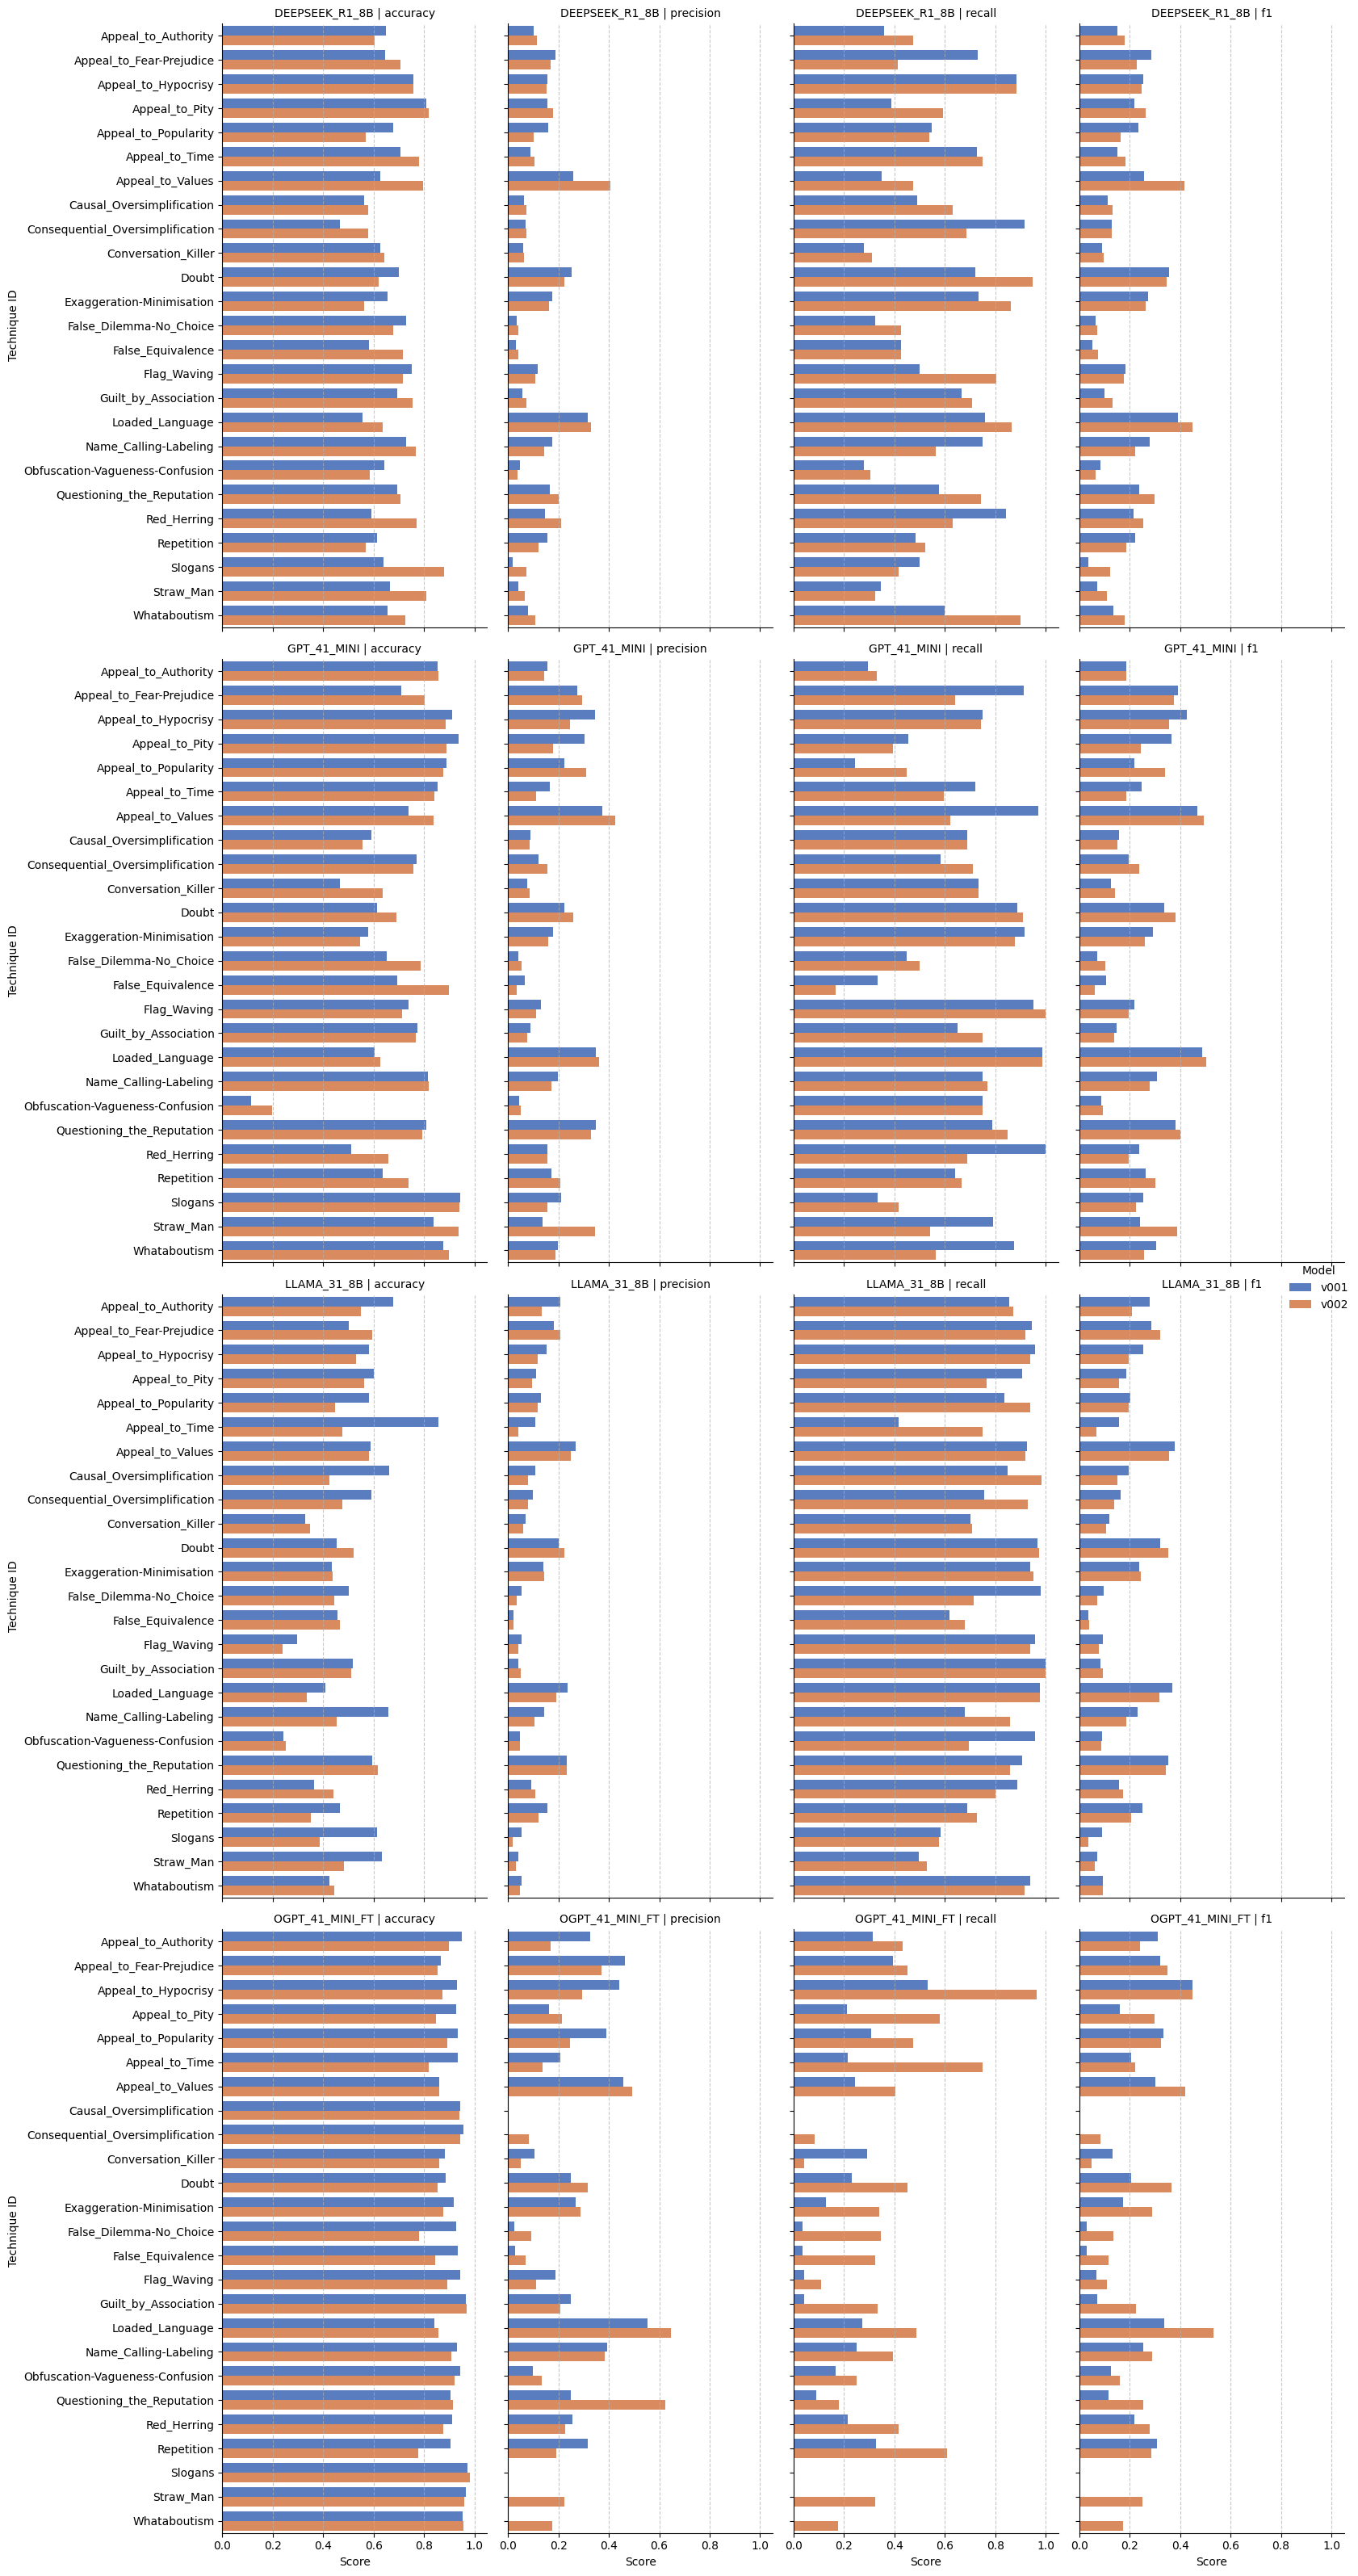

In [16]:
# Filter invalid binary labels
df = df[df["gold"].isin([0, 1]) & df["pred"].isin([0, 1])]
# Explicitly exclude grouping columns from being passed to the function
group_cols = ["prompt_name", "prompt_version", "model", "lang"]
results = compute_groups(df, group_cols=group_cols)

# Melt the results dataframe
metrics_df = results.melt(
    id_vars=["prompt_name", "prompt_version", "model"],
    value_vars=["accuracy", "precision", "recall", "f1"],  # , 'support'],
    var_name="metric",
    value_name="score",
).sort_values(["prompt_name", "prompt_version", "model"])

# Create FacetGrid
g = sns.FacetGrid(
    metrics_df,
    row="model",
    col="metric",
    sharex=True,
    sharey=True,
    height=8,
    aspect=0.5,
)

# Use map_dataframe and assign `hue` in the barplot call
g.map_dataframe(
    sns.barplot,
    x="score",
    y="prompt_name",
    hue="prompt_version",
    errorbar=None,
    palette="muted",
    # legend=False  # Disable auto-legend here
)
# for i, ax in enumerate(g.axes.flat):
#     row_idx, col_idx = divmod(i, g.axes.shape[1])
#     if col_idx != 0:
#         ax.set_ylabel("")
#         ax.set_yticklabels([])

# Add a single legend to the full figure
g.add_legend(title="Model")
g.set_axis_labels("Score", "Technique ID")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
for ax in g.axes.flatten():
    ax.grid(axis="x", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# total

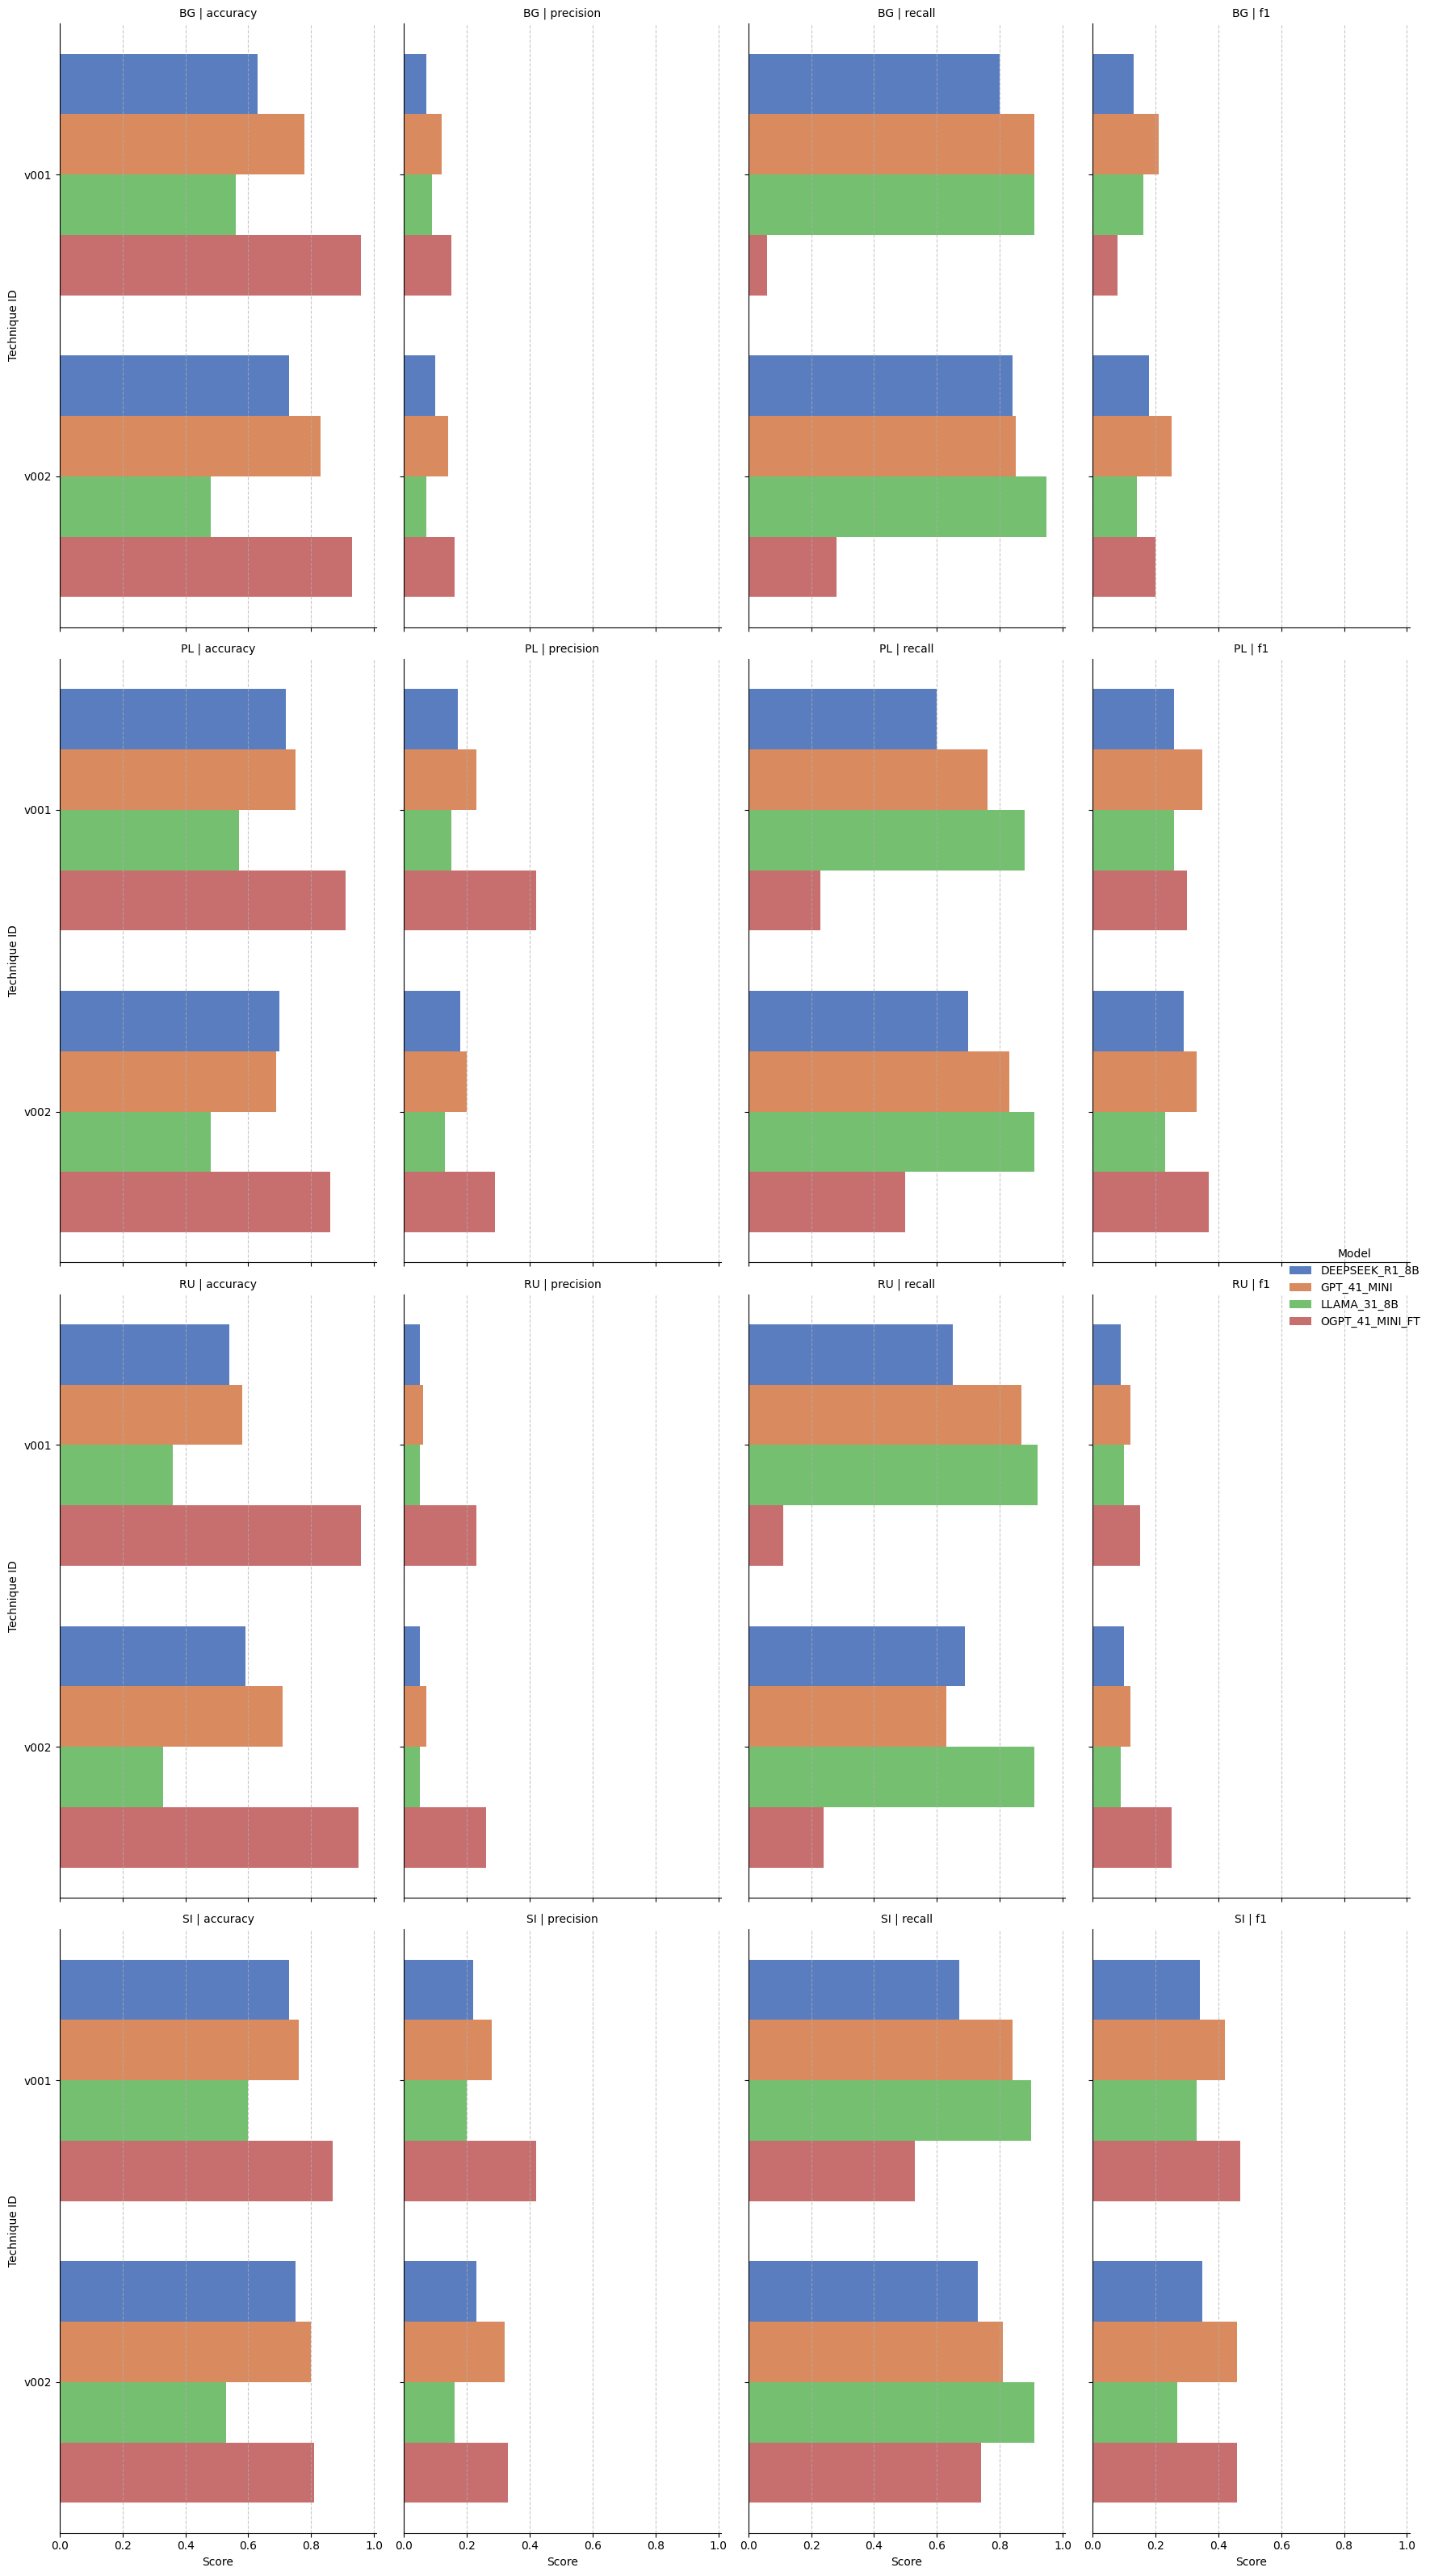

In [17]:
# Filter invalid binary labels
df = df[df["gold"].isin([0, 1]) & df["pred"].isin([0, 1])]
# Explicitly exclude grouping columns from being passed to the function
group_cols = ["model", "prompt_version", "text_lang"]
results = compute_groups(df, group_cols=group_cols)

# Melt the results dataframe
metrics_df = results.melt(
    id_vars=["prompt_version", "text_lang", "model"],
    value_vars=["accuracy", "precision", "recall", "f1"],  # , 'support'],
    var_name="metric",
    value_name="score",
).sort_values(group_cols)

# Create FacetGrid
g = sns.FacetGrid(
    metrics_df,
    row="text_lang",
    col="metric",
    sharex=True,
    sharey=True,
    height=8,
    aspect=0.5,
)

# Use map_dataframe and assign `hue` in the barplot call
g.map_dataframe(
    sns.barplot,
    x="score",
    y="prompt_version",
    hue="model",
    errorbar=None,
    palette="muted",
    # legend=False  # Disable auto-legend here
)


# Add a single legend to the full figure
g.add_legend(title="Model")
g.set_axis_labels("Score", "Technique ID")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
for ax in g.axes.flatten():
    ax.grid(axis="x", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [18]:
results

,model,prompt_version,text_lang,accuracy,precision,recall,f1,support
0,DEEPSEEK_R1_8B,v001,BG,0.63,0.07,0.80,0.13,2500.0
1,DEEPSEEK_R1_8B,v001,PL,0.72,0.17,0.60,0.26,4998.0
2,DEEPSEEK_R1_8B,v001,RU,0.54,0.05,0.65,0.09,2124.0
3,DEEPSEEK_R1_8B,v001,SI,0.73,0.22,0.67,0.34,986.0
4,DEEPSEEK_R1_8B,v002,BG,0.73,0.10,0.84,0.18,2500.0
5,DEEPSEEK_R1_8B,v002,PL,0.70,0.18,0.70,0.29,5490.0
6,DEEPSEEK_R1_8B,v002,RU,0.59,0.05,0.69,0.10,2125.0
7,DEEPSEEK_R1_8B,v002,SI,0.75,0.23,0.73,0.35,972.0
8,GPT_41_MINI,v001,BG,0.78,0.12,0.91,0.21,2480.0
9,GPT_41_MINI,v001,PL,0.75,0.23,0.76,0.35,2476.0
